In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin
import scvi


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag   = '1.9.1.8.5_Dev_final_looser'
model_path='/home/matthew.schmitz/Matthew/models/'+model_tag
adata = sc.read_h5ad(os.path.join(model_path,'analysis_inprogress.h5ad'))
batch_key='batch_name'
discov_key='species'
layer_key='spliced'

In [4]:
adata

AnnData object with n_obs × n_vars = 1854767 × 16738
    obs: 'Class', 'G2M_score', 'S_score', 'Subclass', 'batch_name', 'female', 'general_region', 'log10_n_counts', 'new_ccl', 'new_neighborhood_extended', 'phase', 'region', 'species', 'timepoint', 'general_region_species', '_scvi_discov_ind', '_scvi_batch_ind', 'psi_0', 'psi_1', 'psi_2', 'q_score', 'level_0', 'level_1', 'level_2', 'antipode_cluster', 'kmeans', 'anno_level_2', 'initial_class', 'ic_extended', 'abc_subclass_markercor', 'juv_subclass_markercor', 'linnarson_extended', 'lamanno_class', 'lamanno_subclass', 'lamanno_cluster', 'neighborhood', 'curated_class_label', 'new_neighborhood', 'ccl_extended', 'log_abs_sum_dynam', 'Neighborhood', 'Subclass_markers', 'core_markers', 'clean_cellname', 'singlet', 'msregion', 'doublet', 'n_genes', 'dataset_name', 'individual', 'percent_ribo', 'n_counts', 'full_cellname', 'subclass_markers_level_2', 'clipped_psi_2', 'log_n_genes', '_scvi_batch', '_scvi_labels'
    uns: 'Class_colors', 'Clas

In [5]:
scvi.model.SCVI.setup_anndata(
    adata,
    # layer="UMIs",
    batch_key=batch_key,
    categorical_covariate_keys=[discov_key],
    continuous_covariate_keys=['S_score','G2M_score'],
    
)
model = scvi.model.SCVI(adata, 
                        dispersion="gene-batch", 
                        n_hidden=128, 
                        n_latent=64, 
                        n_layers=3)
model.train(max_epochs=100)

## Save model
model.save(dir_path="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/DevSCVI",overwrite=True)

## Extract integrated space
adata.obsm["X_scVI"] = model.get_latent_representation()

import cuml
umap = cuml.UMAP(n_neighbors = 40,min_dist=0.2,spread=1,metric='manhattan')
adata.obsm["X_umap_scVI"] =umap.fit_transform(adata.obsm['X_scVI'])
adata.obsm["X_umap_scVI"] = antipode.plotting.clip_latent_dimensions(adata.obsm["X_umap_scVI"],0.01)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run 

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [02:33<4:13:39, 153.73s/it, v_num=1, train_loss_step=2.88e+3, train_loss_epoch=3.06e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 3/100:   2%|▏         | 2/100 [05:05<4:09:04, 152.49s/it, v_num=1, train_loss_step=3.01e+3, train_loss_epoch=2.97e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 4/100:   3%|▎         | 3/100 [07:36<4:05:37, 151.93s/it, v_num=1, train_loss_step=2.99e+3, train_loss_epoch=2.93e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 5/100:   4%|▍         | 4/100 [10:14<4:06:40, 154.17s/it, v_num=1, train_loss_step=2.95e+3, train_loss_epoch=2.9e+3] 

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 6/100:   5%|▌         | 5/100 [12:46<4:02:50, 153.38s/it, v_num=1, train_loss_step=2.84e+3, train_loss_epoch=2.88e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 7/100:   6%|▌         | 6/100 [15:14<3:57:30, 151.60s/it, v_num=1, train_loss_step=2.93e+3, train_loss_epoch=2.87e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 8/100:   7%|▋         | 7/100 [17:48<3:56:06, 152.32s/it, v_num=1, train_loss_step=2.89e+3, train_loss_epoch=2.86e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 9/100:   8%|▊         | 8/100 [20:23<3:55:13, 153.41s/it, v_num=1, train_loss_step=2.89e+3, train_loss_epoch=2.85e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 10/100:   9%|▉         | 9/100 [22:55<3:51:56, 152.93s/it, v_num=1, train_loss_step=2.78e+3, train_loss_epoch=2.84e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 11/100:  10%|█         | 10/100 [25:24<3:47:29, 151.67s/it, v_num=1, train_loss_step=2.84e+3, train_loss_epoch=2.83e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 12/100:  11%|█         | 11/100 [28:01<3:47:08, 153.13s/it, v_num=1, train_loss_step=2.87e+3, train_loss_epoch=2.83e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 13/100:  12%|█▏        | 12/100 [30:35<3:45:11, 153.54s/it, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.82e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 14/100:  13%|█▎        | 13/100 [33:06<3:41:29, 152.75s/it, v_num=1, train_loss_step=2.82e+3, train_loss_epoch=2.82e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 15/100:  14%|█▍        | 14/100 [35:34<3:36:43, 151.20s/it, v_num=1, train_loss_step=2.89e+3, train_loss_epoch=2.81e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 16/100:  15%|█▌        | 15/100 [38:11<3:36:40, 152.95s/it, v_num=1, train_loss_step=2.88e+3, train_loss_epoch=2.81e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 17/100:  16%|█▌        | 16/100 [40:45<3:34:39, 153.33s/it, v_num=1, train_loss_step=2.87e+3, train_loss_epoch=2.81e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 18/100:  17%|█▋        | 17/100 [43:17<3:31:26, 152.85s/it, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.8e+3] 

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 19/100:  18%|█▊        | 18/100 [45:45<3:27:12, 151.62s/it, v_num=1, train_loss_step=2.88e+3, train_loss_epoch=2.8e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 20/100:  19%|█▉        | 19/100 [48:23<3:27:00, 153.35s/it, v_num=1, train_loss_step=2.87e+3, train_loss_epoch=2.8e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 21/100:  20%|██        | 20/100 [50:56<3:24:16, 153.21s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.8e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 22/100:  21%|██        | 21/100 [53:25<3:20:21, 152.18s/it, v_num=1, train_loss_step=2.83e+3, train_loss_epoch=2.8e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 23/100:  22%|██▏       | 22/100 [55:52<3:15:49, 150.63s/it, v_num=1, train_loss_step=2.72e+3, train_loss_epoch=2.79e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 24/100:  23%|██▎       | 23/100 [58:19<3:11:55, 149.55s/it, v_num=1, train_loss_step=2.76e+3, train_loss_epoch=2.79e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 25/100:  24%|██▍       | 24/100 [1:00:46<3:08:28, 148.80s/it, v_num=1, train_loss_step=2.78e+3, train_loss_epoch=2.79e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 26/100:  25%|██▌       | 25/100 [1:03:14<3:05:21, 148.29s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.79e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 27/100:  26%|██▌       | 26/100 [1:05:41<3:02:24, 147.89s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.79e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 28/100:  27%|██▋       | 27/100 [1:08:08<2:59:38, 147.65s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.79e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 29/100:  28%|██▊       | 28/100 [1:10:35<2:57:03, 147.55s/it, v_num=1, train_loss_step=2.74e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 30/100:  29%|██▉       | 29/100 [1:13:02<2:54:23, 147.38s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 31/100:  30%|███       | 30/100 [1:15:29<2:51:49, 147.28s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 32/100:  31%|███       | 31/100 [1:17:56<2:49:17, 147.21s/it, v_num=1, train_loss_step=2.76e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 33/100:  32%|███▏      | 32/100 [1:20:23<2:46:48, 147.18s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 34/100:  33%|███▎      | 33/100 [1:22:50<2:44:19, 147.15s/it, v_num=1, train_loss_step=2.76e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 35/100:  34%|███▍      | 34/100 [1:25:17<2:41:48, 147.10s/it, v_num=1, train_loss_step=2.84e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 36/100:  35%|███▌      | 35/100 [1:27:44<2:39:18, 147.06s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 37/100:  36%|███▌      | 36/100 [1:30:11<2:36:50, 147.04s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 38/100:  37%|███▋      | 37/100 [1:32:38<2:34:20, 147.00s/it, v_num=1, train_loss_step=2.82e+3, train_loss_epoch=2.78e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 39/100:  38%|███▊      | 38/100 [1:35:05<2:31:53, 147.00s/it, v_num=1, train_loss_step=2.82e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 40/100:  39%|███▉      | 39/100 [1:37:32<2:29:25, 146.97s/it, v_num=1, train_loss_step=2.76e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 41/100:  40%|████      | 40/100 [1:39:59<2:26:56, 146.94s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 42/100:  41%|████      | 41/100 [1:42:26<2:24:28, 146.93s/it, v_num=1, train_loss_step=2.83e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 43/100:  42%|████▏     | 42/100 [1:44:53<2:22:00, 146.91s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 44/100:  43%|████▎     | 43/100 [1:47:19<2:19:33, 146.90s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 45/100:  44%|████▍     | 44/100 [1:49:46<2:17:07, 146.91s/it, v_num=1, train_loss_step=2.72e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 46/100:  45%|████▌     | 45/100 [1:52:13<2:14:40, 146.91s/it, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 47/100:  46%|████▌     | 46/100 [1:54:40<2:12:11, 146.89s/it, v_num=1, train_loss_step=2.74e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 48/100:  47%|████▋     | 47/100 [1:57:07<2:09:45, 146.89s/it, v_num=1, train_loss_step=2.78e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 49/100:  48%|████▊     | 48/100 [1:59:34<2:07:18, 146.90s/it, v_num=1, train_loss_step=2.8e+3, train_loss_epoch=2.77e+3] 

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 50/100:  49%|████▉     | 49/100 [2:02:01<2:04:55, 146.97s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 51/100:  50%|█████     | 50/100 [2:04:28<2:02:29, 146.98s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 52/100:  51%|█████     | 51/100 [2:06:55<2:00:01, 146.97s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 53/100:  52%|█████▏    | 52/100 [2:09:22<1:57:34, 146.98s/it, v_num=1, train_loss_step=2.82e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 54/100:  53%|█████▎    | 53/100 [2:11:49<1:55:08, 147.00s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 55/100:  54%|█████▍    | 54/100 [2:14:16<1:52:42, 147.00s/it, v_num=1, train_loss_step=2.78e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 56/100:  55%|█████▌    | 55/100 [2:16:43<1:50:14, 147.00s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.77e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 57/100:  56%|█████▌    | 56/100 [2:19:10<1:47:47, 146.99s/it, v_num=1, train_loss_step=2.8e+3, train_loss_epoch=2.76e+3] 

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 58/100:  57%|█████▋    | 57/100 [2:21:37<1:45:20, 146.99s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 59/100:  58%|█████▊    | 58/100 [2:24:04<1:42:52, 146.97s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 60/100:  59%|█████▉    | 59/100 [2:26:31<1:40:26, 146.98s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 61/100:  60%|██████    | 60/100 [2:28:58<1:37:58, 146.97s/it, v_num=1, train_loss_step=2.81e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 62/100:  61%|██████    | 61/100 [2:31:25<1:35:33, 147.00s/it, v_num=1, train_loss_step=2.7e+3, train_loss_epoch=2.76e+3] 

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 63/100:  62%|██████▏   | 62/100 [2:33:52<1:33:07, 147.03s/it, v_num=1, train_loss_step=2.78e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 64/100:  63%|██████▎   | 63/100 [2:36:19<1:30:38, 146.98s/it, v_num=1, train_loss_step=2.86e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 65/100:  64%|██████▍   | 64/100 [2:38:46<1:28:11, 146.98s/it, v_num=1, train_loss_step=2.92e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 66/100:  65%|██████▌   | 65/100 [2:41:13<1:25:43, 146.97s/it, v_num=1, train_loss_step=2.82e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 67/100:  66%|██████▌   | 66/100 [2:43:40<1:23:16, 146.94s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 68/100:  67%|██████▋   | 67/100 [2:46:07<1:20:48, 146.93s/it, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 69/100:  68%|██████▊   | 68/100 [2:48:34<1:18:21, 146.94s/it, v_num=1, train_loss_step=2.74e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 70/100:  69%|██████▉   | 69/100 [2:51:01<1:15:55, 146.96s/it, v_num=1, train_loss_step=2.8e+3, train_loss_epoch=2.76e+3] 

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 71/100:  70%|███████   | 70/100 [2:53:27<1:13:28, 146.93s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 72/100:  71%|███████   | 71/100 [2:55:54<1:11:00, 146.93s/it, v_num=1, train_loss_step=2.74e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 73/100:  72%|███████▏  | 72/100 [2:58:21<1:08:34, 146.93s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 74/100:  73%|███████▎  | 73/100 [3:00:48<1:06:06, 146.90s/it, v_num=1, train_loss_step=2.74e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 75/100:  74%|███████▍  | 74/100 [3:03:15<1:03:39, 146.90s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 76/100:  75%|███████▌  | 75/100 [3:05:42<1:01:12, 146.89s/it, v_num=1, train_loss_step=2.82e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 77/100:  76%|███████▌  | 76/100 [3:08:09<58:45, 146.91s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.76e+3]  

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 78/100:  77%|███████▋  | 77/100 [3:10:36<56:19, 146.94s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 79/100:  78%|███████▊  | 78/100 [3:13:03<53:52, 146.95s/it, v_num=1, train_loss_step=2.83e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 80/100:  79%|███████▉  | 79/100 [3:15:30<51:25, 146.95s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 81/100:  80%|████████  | 80/100 [3:17:57<48:59, 146.98s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 82/100:  81%|████████  | 81/100 [3:20:24<46:32, 146.97s/it, v_num=1, train_loss_step=2.68e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 83/100:  82%|████████▏ | 82/100 [3:22:51<44:05, 146.95s/it, v_num=1, train_loss_step=2.65e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 84/100:  83%|████████▎ | 83/100 [3:25:18<41:38, 146.96s/it, v_num=1, train_loss_step=2.79e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 85/100:  84%|████████▍ | 84/100 [3:27:45<39:11, 146.96s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 86/100:  85%|████████▌ | 85/100 [3:30:12<36:44, 146.98s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 87/100:  86%|████████▌ | 86/100 [3:32:39<34:17, 146.99s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 88/100:  87%|████████▋ | 87/100 [3:35:06<31:50, 146.98s/it, v_num=1, train_loss_step=2.7e+3, train_loss_epoch=2.76e+3] 

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 89/100:  88%|████████▊ | 88/100 [3:37:33<29:23, 146.99s/it, v_num=1, train_loss_step=2.7e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 90/100:  89%|████████▉ | 89/100 [3:40:00<26:56, 146.98s/it, v_num=1, train_loss_step=2.73e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 91/100:  90%|█████████ | 90/100 [3:42:27<24:30, 147.00s/it, v_num=1, train_loss_step=2.69e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 92/100:  91%|█████████ | 91/100 [3:44:54<22:03, 147.01s/it, v_num=1, train_loss_step=2.83e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 93/100:  92%|█████████▏| 92/100 [3:47:21<19:35, 146.97s/it, v_num=1, train_loss_step=2.74e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 94/100:  93%|█████████▎| 93/100 [3:49:48<17:09, 147.01s/it, v_num=1, train_loss_step=2.76e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 95/100:  94%|█████████▍| 94/100 [3:52:15<14:42, 147.01s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 96/100:  95%|█████████▌| 95/100 [3:54:42<12:15, 147.01s/it, v_num=1, train_loss_step=2.73e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 97/100:  96%|█████████▌| 96/100 [3:57:09<09:48, 147.06s/it, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 98/100:  97%|█████████▋| 97/100 [3:59:36<07:21, 147.07s/it, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 99/100:  98%|█████████▊| 98/100 [4:02:03<04:54, 147.08s/it, v_num=1, train_loss_step=2.75e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 100/100:  99%|█████████▉| 99/100 [4:04:30<02:27, 147.09s/it, v_num=1, train_loss_step=2.8e+3, train_loss_epoch=2.76e+3]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [4:06:57<00:00, 147.12s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.76e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [4:06:57<00:00, 148.18s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.76e+3]


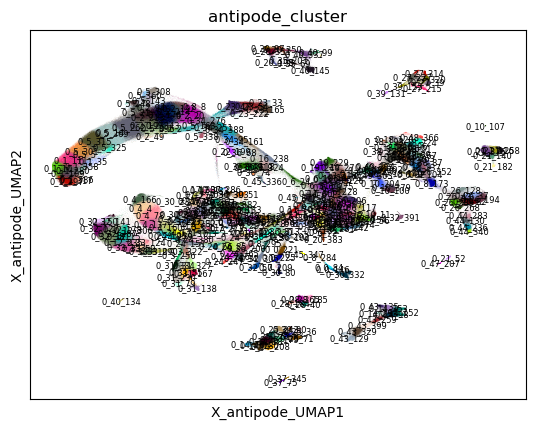

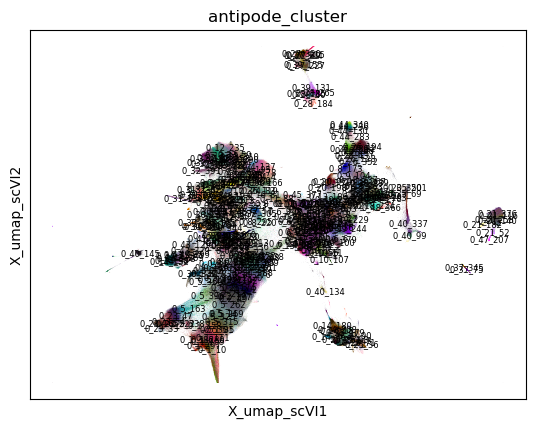

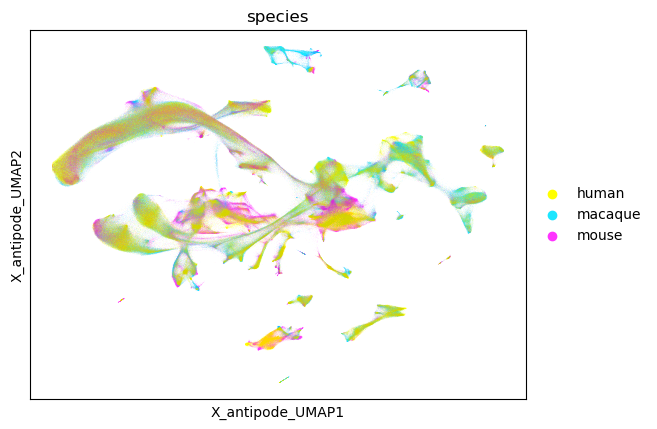

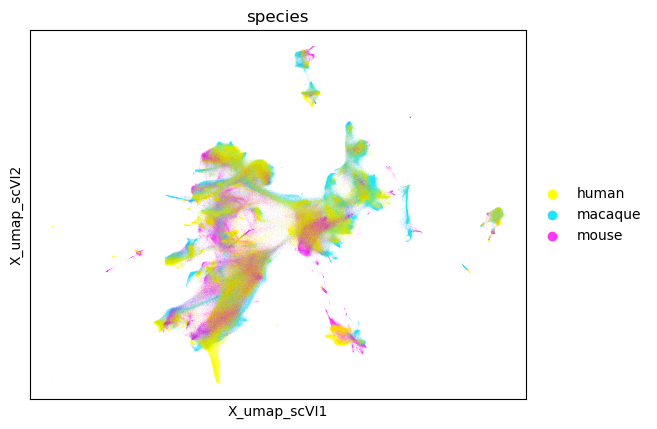

In [12]:
sc.pl.embedding(
    adata,
    basis='X_antipode_UMAP',
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis='X_antipode_UMAP',
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key]
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key]
)

In [19]:
np.savetxt(os.path.join(model_path,f"X_scVI.csv"), adata.obsm['X_scVI'], delimiter=",")
np.savetxt(os.path.join(model_path,f"X_umap_scVI.csv"), adata.obsm['X_umap_scVI'], delimiter=",")
np.savetxt(os.path.join(model_path,f"X_antipode_UMAP.csv"), adata.obsm['X_antipode_UMAP'], delimiter=",")



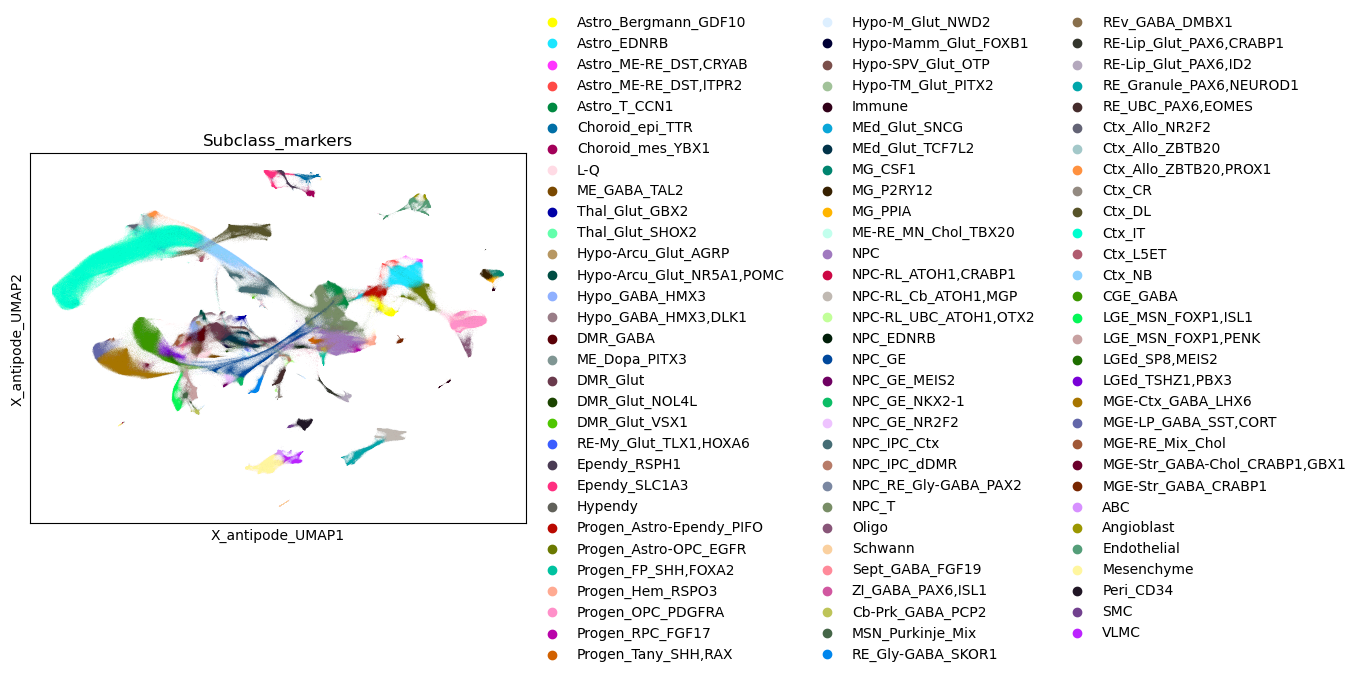

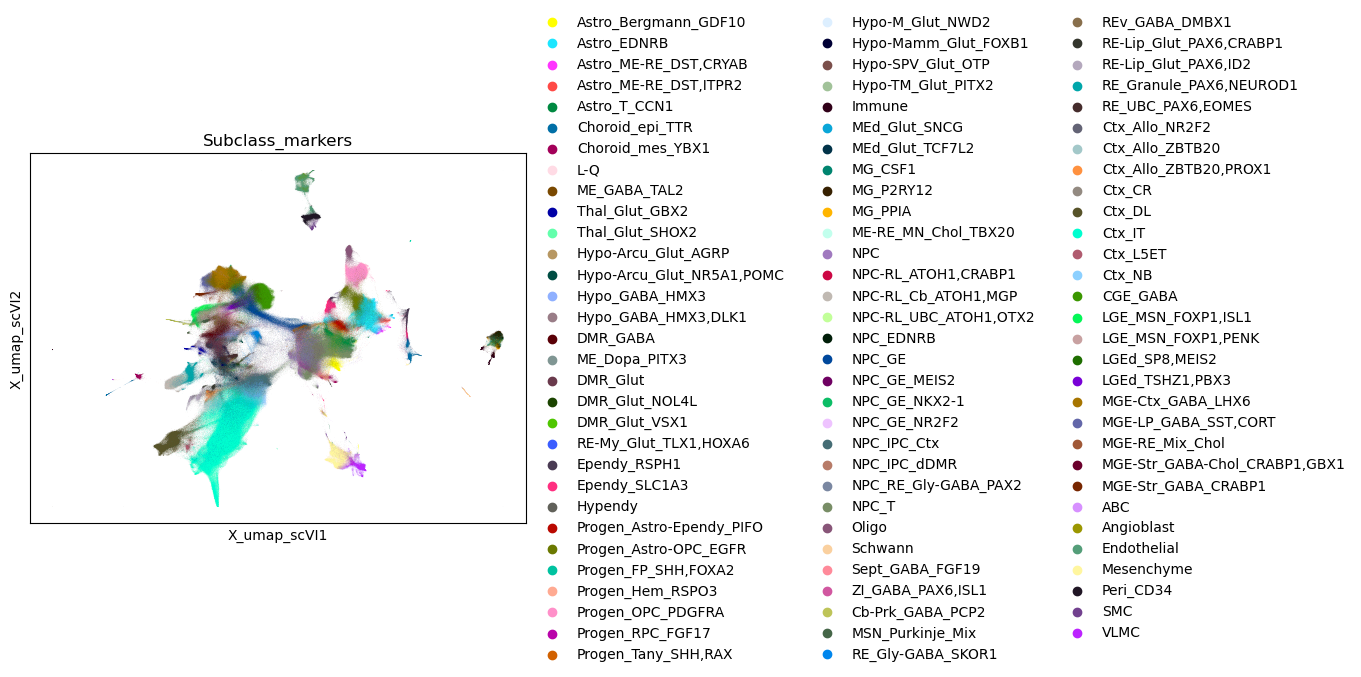

In [15]:
sc.pl.embedding(
    adata,
    basis='X_antipode_UMAP',
    palette=sc.pl.palettes.godsnot_102,
    color=['Subclass_markers']
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    palette=sc.pl.palettes.godsnot_102,
    color=['Subclass_markers']
)

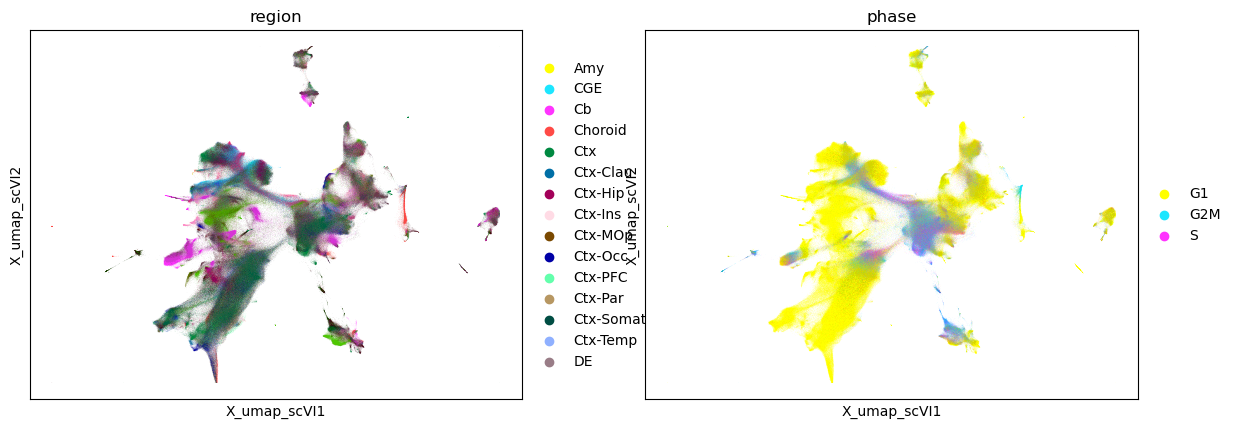

In [18]:
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    palette=sc.pl.palettes.godsnot_102,
    color=['region','phase']
)